In [41]:
import random
from operator import attrgetter
import time
import copy as cp
import dask
import pandas as pd

In [42]:
from dask.distributed import Client, progress

client = Client()
client

Client Scheduler: tcp://127.0.0.1:59521 Dashboard: http://127.0.0.1:59522/status,Cluster Workers: 8 Cores: 8 Memory: 8.42 GB


In [43]:
def convert(ruta): 
    s = [str(i) for i in ruta] 
    ruta_c = "-".join(s)
    return(ruta_c) 

In [44]:
class Utileria():

    # Función para calcular la distancia entre coordenadas en la tierra (esfera)
    # Recibe las coordenaas del punto A, del punto B y las unidades en las que se realizará el cálculo
    # Devuelve la distancia de acuerdo a la unidad especificada (por defecto km)
    def calcular_distancia_coord(self, nbr_LongA, nbr_LatA, nbr_LongB, nbr_LatB, str_unidad='km'):
        from math import radians, cos, sin, asin, sqrt

        # primero se convierte todo a radianes
        nbr_LongA = radians(nbr_LongA)
        nbr_LatA = radians(nbr_LatA)
        nbr_LongB = radians(nbr_LongB)
        nbr_LatB = radians(nbr_LatB)

        # Aplicamos la fórmula de Haversine
        nbr_delta_lon = nbr_LongB - nbr_LongA
        nbr_delta_lat = nbr_LatB - nbr_LatA
        nbr_a = sin(nbr_delta_lat / 2)**2 + cos(nbr_LatA) * cos(nbr_LatB) * sin(nbr_delta_lon / 2)**2

        nbr_c = 2 * asin(sqrt(nbr_a))

        # Dependiendo del tipo de unidad especificada, sera el valor que usaremos como radio
        # La tierra no es una esfera perfecta, asi que usaremos un radio entre el ecuatorial y el polar
        if str_unidad == 'km':
            nbr_r = 6371
        elif str_unidad == 'miles':
            nbr_r = 3956
        else:
            print('Se especificó una unidad de medición no válida. No es posible realizar el cálculo')
            return 0

        nbr_resultado = nbr_c * nbr_r

        return nbr_resultado


In [64]:
def ruta(df, fv):
    df1 = df[(df.fza_ventas == fv)]
    dfo = df1.filter(['fza_ventas', 'id_origen', 'lat_origen', 'lon_origen'], axis=1).drop_duplicates()
    dfo = dfo.rename({'id_origen': 'id', 'lat_origen': 'lat', 'lon_origen': 'lon'}, axis=1)
    dfd = df1.filter(['fza_ventas', 'no_cliente', 'lat_destino','lon_destino'], axis=1)
    dfd = dfd.rename({'no_cliente': 'id', 'lat_destino': 'lat', 'lon_destino': 'lon'}, axis=1)
    df2 = pd.concat([dfo, dfd])
    df2['posicion'] = 0
    df2['posicion'] = df2.groupby(['posicion']).cumcount()+1
    
    dm = []
    #ut=Utileria()
    for i in range(df2.shape[0]):
        for j in range(i+1, df2.shape[0]):
            d=ut.calcular_distancia_coord(df2.iloc[i, 3], df2.iloc[i, 2],  df2.iloc[j, 3], df2.iloc[j, 2])
            elemento = [df2.iloc[i,4], df2.iloc[j,4], d]
            dm.append(elemento)
    return dm

In [65]:
class Particula():

    list_CaminoActual = []
    list_MejorCamino = []
    nbr_CostoCaminoActual = 0
    nbr_CostoMejorCamino = 0
    velocidad = []

    def __init__(self, par_camino, par_costo):

        self.list_CaminoActual = par_camino
        self.list_MejorCamino = par_camino
        self.nbr_CostoCaminoActual = par_costo
        self.nbr_CostoMejorCamino = par_costo
        self.velocidad = []

In [66]:
class Grafo():

    dict_Nodos = {}
    conj_Nodos = set()  # No hay repeticiones
    nbr_CantNodos = 0
    df_Grafo = None

    def __init__(self, par_df):
        self.df_Grafo = par_df
        self.GenerarGrafo()
        self.nbr_CantNodos = len(self.conj_Nodos)

    def GenerarGrafo(self):

        # Barremos las filas del data frame para generar el grafo
        for fila in self.df_Grafo:
            # Las distacias son las mismas en ambos sentidos
            self.AgregarNodoAGrafo(fila[0], fila[1], fila[2])
            self.AgregarNodoAGrafo(fila[1], fila[0], fila[2])

    def AgregarNodoAGrafo(self, par_Origen, par_Destino, par_Costo):

        if not self.ExisteNodo(par_Origen, par_Destino):
            self.dict_Nodos[(par_Origen, par_Destino)] = par_Costo
            self.conj_Nodos.add(par_Origen)
            self.conj_Nodos.add(par_Destino)

    def ExisteNodo(self, par_Origen, par_Destino):
        if (par_Origen, par_Destino) in self.dict_Nodos:
            return True
        else:
            return False

    def MostrarGrafo(self):
        print('Grafo:\n')
        for Nodo in self.dict_Nodos:
            print('%d conectado con: %d. Costo: %d' % (Nodo[0], Nodo[1], self.dict_Nodos[Nodo]))

    def CostoDelCamino(self, camino):

        nbr_CostoTotal = 0
        for i in range(self.nbr_CantNodos - 1):
            nbr_CostoTotal += self.dict_Nodos[(camino[i], camino[i+1])]

        nbr_CostoTotal += self.dict_Nodos[(camino[self.nbr_CantNodos - 1], camino[0])]
        return nbr_CostoTotal

    def GenerarCaminosAleatorios(self, max_size):

        list_CaminosAleatorio, list_Nodos = [], list(self.conj_Nodos)

        initial_vertice = random.choice(list_Nodos)

        list_Nodos.remove(initial_vertice)
        list_Nodos.insert(0, initial_vertice)

        for i in range(max_size):
            list_temp = list_Nodos[1:]
            random.shuffle(list_temp)
            list_temp.insert(0, initial_vertice)

            if list_temp not in list_CaminosAleatorio:
                list_CaminosAleatorio.append(list_temp)

        return list_CaminosAleatorio

In [67]:
class ParticleSwarm():

    # Atributos generales para la ejecución
    df_Datos = ''
    str_TipoEjec = ''

    # Hiperparámetros del algoritmo
    nbr_Iteraciones = 0
    nbr_CantPartic = 0
    nbr_Alfa = 0
    nbr_Beta = 0

    # Atributos de resultados de la ejecución
    nbr_TiempoEjec = 0
    nbr_MejorCosto = 0
    lst_MejorCamino = []

    # Atributo auxiliar
    list_Particulas = []

    def __init__(self, par_Datos, par_TipoEjec, par_HiperParam):

        # Datos y tipo de ejecución
        self.df_Datos = par_Datos
        self.str_TipoEjec = par_TipoEjec

        # Hiperparámetros del algoritmo
        self.nbr_Iteraciones = par_HiperParam.get('Iteraciones')
        self.nbr_CantPartic = par_HiperParam.get('Particulas')
        self.nbr_Alfa = par_HiperParam.get('Alfa')
        self.nbr_Beta = par_HiperParam.get('Beta')

        #################

        self.Grafo = Grafo(self.df_Datos)
        list_CaminosAleatorios = self.Grafo.GenerarCaminosAleatorios(self.nbr_CantPartic)
        for list_CaminoAleatorio in list_CaminosAleatorios:
            particula = Particula(list_CaminoAleatorio, self.Grafo.CostoDelCamino(list_CaminoAleatorio))
            self.list_Particulas .append(particula)

        # updates "size_population"
        self.nbr_CantPartic = len(self.list_Particulas)

    def Ejecutar(self):

        # Tomamos la hora de inicio
        tm_inicio = time.time()

        # Se corre el algorimto secuencial o en paralelo según los parámetros
        if self.str_TipoEjec == 'SEQ':
            self.Secuencial()
        elif self.str_TipoEjec == 'PAR':
            self.Paralelo()
            
        self.lst_MejorCamino = self.obj_MejorParticula.list_MejorCamino
        self.nbr_MejorCosto = self.obj_MejorParticula.nbr_CostoMejorCamino

        # Se toma la hora de fin del algoritmo, y se almacena la duración
        tm_final = time.time()
        self.nbr_TiempoEjec = tm_final - tm_inicio

    def Secuencial(self):

        for t in range(self.nbr_Iteraciones):

            self.obj_MejorParticula = min(self.list_Particulas, key=attrgetter('nbr_CostoMejorCamino'))

            for particula in self.list_Particulas:

                particula = self.ProcesoXParticula(particula, self.obj_MejorParticula)

    def Paralelo(self):

        # Por ejemplo
        for t in range(self.nbr_Iteraciones):

            self.obj_MejorParticula = min(self.list_Particulas, key=attrgetter('nbr_CostoMejorCamino'))

            list_Particulas_Temp = []
            for particula in self.list_Particulas:

                dask_Particula = self.ProcesoXParticulaParalelo(particula, self.obj_MejorParticula)
                list_Particulas_Temp.append(dask_Particula)

            dask_Dummy1 = self.JuntarParticulas(list_Particulas_Temp)
            dask_Dummy2 = dask_Dummy1.compute()
            list_Final = dask_Dummy2[0]
            self.list_Particulas = list_Final

    @dask.delayed
    def JuntarParticulas(self, *argv):
        return argv

    @dask.delayed
    def ProcesoXParticulaParalelo(self, particle, par_gbest):
        return self.ProcesoXParticula(particle, par_gbest)

    def ProcesoXParticula(self, particula, par_gbest):

        # time.sleep(.01)
        del particula.velocidad[:]

        list_VelocidadTemp = []
        list_MejorCaminoGlob = cp.copy(self.obj_MejorParticula.list_MejorCamino)
        list_MejorCaminoPart = particula.list_MejorCamino[:]
        list_CaminoParticula = particula.list_CaminoActual[:]

        list_VelocidadTemp_p = self.Swap(list_CaminoParticula, list_MejorCaminoPart, self.nbr_Alfa)

        list_VelocidadTemp_g = self.Swap(list_CaminoParticula, list_MejorCaminoGlob, self.nbr_Beta)

        list_VelocidadTemp_t = self.JuntarListasSwaps(list_VelocidadTemp_p, list_VelocidadTemp_g)
        list_VelocidadTemp = list_VelocidadTemp_t

        particula.velocidad = list_VelocidadTemp

        # Generación de nuevo camino para la particula
        for tup_Swarm in list_VelocidadTemp:

            if random.random() <= tup_Swarm[2]:
                aux = list_CaminoParticula[tup_Swarm[0]]
                list_CaminoParticula[tup_Swarm[0]] = list_CaminoParticula[tup_Swarm[1]]
                list_CaminoParticula[tup_Swarm[1]] = aux

        particula.list_CaminoActual = list_CaminoParticula
        nbr_CostoCaminoActual = self.Grafo.CostoDelCamino(list_CaminoParticula)
        particula.nbr_CostoCaminoActual = nbr_CostoCaminoActual

        if nbr_CostoCaminoActual < particula.nbr_CostoMejorCamino:
            particula.list_MejorCamino = list_CaminoParticula
            particula.nbr_CostoMejorCamino = nbr_CostoCaminoActual

        return particula

    # @dask.delayed
    def Swap(self, par_CaminoParticula, par_MejorCamino, par_AlphaBeta):
        list_VelocidadTemp = []
        for i in range(self.Grafo.nbr_CantNodos):
            if par_CaminoParticula[i] != par_MejorCamino[i]:

                tup_Swarm = (i, par_MejorCamino.index(par_CaminoParticula[i]), par_AlphaBeta)
                list_VelocidadTemp.append(tup_Swarm)

                # Hacemos el intercambio
                aux = par_MejorCamino[tup_Swarm[0]]
                par_MejorCamino[tup_Swarm[0]] = par_MejorCamino[tup_Swarm[1]]
                par_MejorCamino[tup_Swarm[1]] = aux

        return list_VelocidadTemp

    # @dask.delayed
    def JuntarListasSwaps(self, list1, list2):
        total = list1 + list2
        return total

In [68]:
#Cargamos el csv con los datos
df = pd.read_csv("C:/Users/anabc/Documents/MCD/Primavera2020/MNO/Proyecto final/data/raw/raw.csv", sep = ',',encoding='latin-1')

In [69]:
df.head()

,fza_ventas,no_cliente,lat_destino,lon_destino,id_origen,estado,lat_origen,lon_origen
0,123,10295095,25.784806,-100.398120,11388,Nuevo León,25.7789,-100.387
1,123,1010290203,25.783903,-100.394513,11388,Nuevo León,25.7789,-100.387
2,123,1010290279,25.777878,-100.400035,11388,Nuevo León,25.7789,-100.387
3,123,1010291206,25.762408,-100.395350,11388,Nuevo León,25.7789,-100.387
4,123,1010291416,25.773274,-100.409759,11388,Nuevo León,25.7789,-100.387


In [50]:
ut=Utileria()
fv = 123
#1143 3 puntos
#94459 6 puntos
dm=ruta(df, fv)

C:\Users\anabc\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  import sys


In [71]:
######################################## Código para hacer pruebas ########################################

rutas = pd.DataFrame(index=range(10),columns=['Costo', 'Tiempo', 'Ruta'])

# Para recibir este dataframe, sólo dime en qué formato me lo mandas, y
# adapto la clase para leerlo.
#df_Dummy = [[1, 2, 1.445375218],
#            [1, 3, 8.855215471],
#            [1, 4, 8.14387567],
#            [2, 3, 7.598907453], 
#            [2, 4, 6.980045187],
#            [3, 4, 1.138791437]
#            ]

dict_Hiper = {'Iteraciones': 10,
              'Particulas': 10,
              'Alfa': .9,
              'Beta': 1
              }

# Instanciamos el objeto
for i in range(10):
    PS = ParticleSwarm(dm, 'SEQ', dict_Hiper)
# PS = ParticleSwarm(df_Dummy, 'PAR', dict_Hiper)
# PS.Grafo.MostrarGrafo()
# Se ejecuta el algoritmo


    PS.Ejecutar()
    rutas.Costo[i] = PS.nbr_MejorCosto
    rutas.Tiempo[i] = PS.nbr_TiempoEjec
    rutas.Ruta[i] = convert(PS.lst_MejorCamino)
    

# Ya que terminó, se pueden obtener los resultados de la corrida:
    #print('PS.nbr_TiempoEjec: ', PS.nbr_TiempoEjec)
    #print('PS.nbr_MejorCosto: ', PS.nbr_MejorCosto)
    #print('PS.lst_MejorCamino: ', PS.lst_MejorCamino)

### Análisis de las rutas, tiempos de ejecución y costos

In [72]:
rutas['Costo']=rutas['Costo'].astype(float);
rutas['Tiempo']=rutas['Tiempo'].astype(float);

In [73]:
rutas.head()

,Costo,Tiempo,Ruta
0,41.889941,0.007978,8.0-27.0-10.0-2.0-20.0-17.0-18.0-12.0-6.0-16.0...
1,39.768217,0.016096,8.0-30.0-25.0-2.0-13.0-17.0-23.0-24.0-20.0-11....
2,39.046272,0.018989,2.0-18.0-23.0-28.0-13.0-14.0-6.0-10.0-20.0-17....
3,37.894857,0.024896,9.0-12.0-7.0-11.0-13.0-18.0-23.0-15.0-14.0-26....
4,37.894857,0.032869,9.0-12.0-7.0-11.0-13.0-18.0-23.0-15.0-14.0-26....


In [58]:
rutas.describe()

,Costo,Tiempo
count,10.000000,10.000000
mean,36.634965,0.035406
std,3.642581,0.014211
min,30.591733,0.008976
25%,34.198960,0.024958
50%,36.382386,0.038413
75%,39.667183,0.043838
max,42.456064,0.052820


Text(0.5,0,'KM')

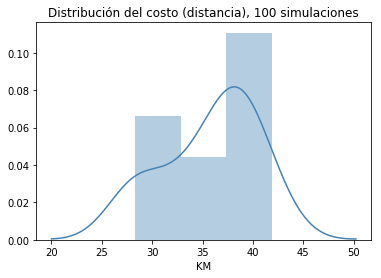

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(rutas.Costo, color="steelblue")
plt.title('Distribución del costo (distancia), 100 simulaciones')
plt.xlabel('KM', fontsize=10)

Text(0.5,0,'Tiempo')

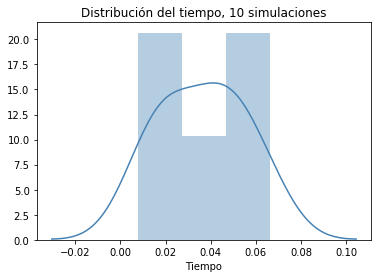

In [75]:
sns.distplot(rutas.Tiempo, color="steelblue")
plt.title('Distribución del tiempo, 10 simulaciones')
plt.xlabel('Tiempo', fontsize=10)

In [62]:
resumen = rutas.groupby('Ruta').size().reset_index(name='Count').rename(columns={'Col1':'Col_value'})
resumen

,Ruta,Count
0,12.0-29.0-8.0-4.0-16.0-18.0-7.0-20.0-14.0-25.0...,1
1,23.0-12.0-26.0-5.0-27.0-30.0-7.0-4.0-8.0-10.0-...,1
2,27.0-29.0-8.0-24.0-14.0-18.0-7.0-9.0-10.0-30.0...,1
3,27.0-29.0-8.0-24.0-5.0-18.0-7.0-20.0-11.0-6.0-...,1
4,27.0-29.0-8.0-30.0-16.0-18.0-7.0-20.0-14.0-5.0...,2
5,27.0-29.0-8.0-4.0-10.0-22.0-7.0-20.0-12.0-19.0...,2
6,27.0-29.0-8.0-4.0-10.0-22.0-7.0-20.0-12.0-25.0...,1
7,27.0-29.0-8.0-4.0-16.0-18.0-7.0-20.0-14.0-25.0...,1


In [76]:
rutas.Ruta[1]

'8.0-30.0-25.0-2.0-13.0-17.0-23.0-24.0-20.0-11.0-22.0-7.0-18.0-14.0-6.0-28.0-3.0-21.0-27.0-5.0-10.0-26.0-12.0-16.0-9.0-29.0-4.0-19.0-1.0-15.0'